# Homework 4

Use this notebook as a starter

# Import Libraries

In [29]:
#import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [30]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

zsh:1: command not found: wget


# Preparation

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [31]:
#load dataset
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [32]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)


Prepare the numerical variables:

In [33]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [34]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [35]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

# Your code

What are the categorical variables? What are the numerical?

In [36]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [48]:
categorical = ["home", "material", "records", "job"]
numerical = ["seniority", "time", "age","expenses", "income", "assets", "debt", "amount", "price"]

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
#perform the train/validation/test split with scikit-learn
df_full_train, df_test = train_test_split(df, test_size =0.2, random_state =1)
df_train, df_val = train_test_split(df_full_train, test_size =0.25, random_state =1)

In [51]:
# check partitions sizes
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [52]:
#make index not shuffeled 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [53]:
#target variables of all partitions
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

In [54]:
#delete default values from all dfs
del df_train ['default']
del df_val ['default']
del df_test ['default']

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the "default" variable
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [55]:
from sklearn.metrics import roc_auc_score

In [56]:
for i in numerical:
    AUC = roc_auc_score(y_train, df_train[i])
    if AUC < 0.5:
        AUC = roc_auc_score(y_train, -df_train[i])
    print(f'AUC of {i}: {AUC}')

AUC of seniority: 0.7093778624491943
AUC of time: 0.5608662489595051
AUC of age: 0.5732933272499939
AUC of expenses: 0.5009184217217011
AUC of income: 0.682006666132633
AUC of assets: 0.6486042567122802
AUC of debt: 0.5047829675783548
AUC of amount: 0.5910773431595518
AUC of price: 0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?



- seniority -> HIGHEST AUC
- time
- income
- debt

# Training the model

From now on, use these columns only:



['seniority', 'income', 'assets', 'records', 'job', 'home']


Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [60]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [61]:
df_train_small = df_train[features]
df_test_small = df_test[features]
df_val_small = df_val[features]

In [62]:
from sklearn.feature_extraction import DictVectorizer

In [63]:
#dictionaries to apply one-hot-encoding on categorical features 
train_dict = df_train_small.to_dict(orient='records')

In [65]:
#feature matrix = numerical + one-hot encoded categorical variables
dv = DictVectorizer()
X_train_small = dv.fit_transform(train_dict)
X_train_small

<2672x17 sparse matrix of type '<class 'numpy.float64'>'
	with 16032 stored elements in Compressed Sparse Row format>

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
#LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_small, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [68]:
val_dict = df_val_small.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

In [69]:
y_pred = model.predict_proba(X_val)[:, 1]

# Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [71]:
AUC_val = round(roc_auc_score(y_val, y_pred),3)
AUC_val

0.812

# Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [82]:
def pr(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum() 

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [83]:
pr = pr(y_val, y_pred)

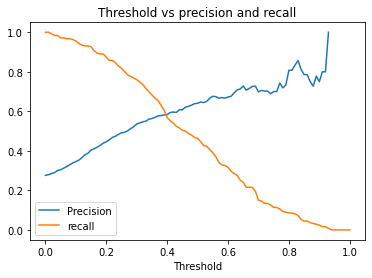

In [89]:
plt.plot(pr.threshold, pr['precision'], label='Precision')
plt.plot(pr.threshold, pr['recall'], label='recall')
plt.title('Threshold vs precision and recall')
plt.xlabel('Threshold')
plt.legend()

At which threshold precision and recall curves intersect?

- 0.2
- 0.4 -> precision and recall curves intersection
- 0.6
- 0.8

# Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [118]:
pr["F1_score"] = 2*(pr ["precision"]*pr ["recall"])/(pr["precision"]+ pr["recall"])
pr[pr["F1_score"] == pr.F1_score]

,threshold,tp,fp,fn,tn,precision,recall,F1_score
0,0.00,246,645,0,0,0.276094,1.000000,0.432718
1,0.01,246,635,0,10,0.279228,1.000000,0.436557
2,0.02,244,613,2,32,0.284714,0.991870,0.442430
3,0.03,242,593,4,52,0.289820,0.983740,0.447734
4,0.04,242,563,4,82,0.300621,0.983740,0.460514
...,...,...,...,...,...,...,...,...
89,0.89,7,2,239,643,0.777778,0.028455,0.054902
90,0.90,6,2,240,643,0.750000,0.024390,0.047244
91,0.91,4,1,242,644,0.800000,0.016260,0.031873
92,0.92,4,1,242,644,0.800000,0.016260,0.031873


At which threshold F1 is maximal?

- 0.1
- 0.3 -> threshold of f1 max
- 0.5
- 0.7


In [119]:
pr["F1_score"] = 2*(pr ["precision"]*pr ["recall"])/(pr["precision"]+ pr["recall"])
pr[pr["F1_score"] == pr.F1_score.max()]

,threshold,tp,fp,fn,tn,precision,recall,F1_score
30,0.3,187,162,59,483,0.535817,0.760163,0.628571


# Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

In [98]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [99]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [100]:
from sklearn.model_selection import KFold

In [104]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'Mean: {round(np.mean(scores),4)}\n Std: {round(np.std(scores),4)}')

Mean: 0.8142
 Std: 0.0146


How large is standard devidation of the scores across different folds?



- 0.001
- 0.014 --> std
- 0.09
- 0.14

# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [109]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.808 ± 0.012
C=0.1, auc = 0.813 ± 0.014
C=1, auc = 0.814 ± 0.015
C=10, auc = 0.814 ± 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1 -> best mean score 
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

# THANK YOU :) 